# 04. Charlotte Shapefile -- buffer

~~Following the previous notebook, there was a problem when calculating the radius around points. Namely, I used an equal area projection, and when projected back into EPSG:4269 (NAD83) I could see the shapes were messed up.~~

~~This same problem is a hassle for the Voronoi diagram, so, if we are going for it, it is better to use a GIS function (and give preference if it has a Manhattan distance, as it provides usually a more accurate scenario under cities). Example function: [Hmm][1]~~

The previous notebook calculated the buffer area and voronoi diagrams over an Albert's Equal Area projection. This is not perfect, as the projection may produce some distortions. Below, I will compute the exact buffer around points. If you compare both values, you can see that the current display precision is not enough to verify the projections distortion under AEA. Therefore, I conclude that it is enough for the problem and I will use it, since the exact method would be more complex.

Also, infering from that, we can assume that the Voronoi diagram generated is a good representation of the real Voronoi diagram that would be generated if the Earth's shape was taken into account.

[1]: http://pro.arcgis.com/en/pro-app/tool-reference/analysis/create-thiessen-polygons.htm

# Load shapefiles

In [1]:
import functools
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.ops
import pyproj
from shapely.geometry import Point

from cpe_help import Department, util
from cpe_help.tiger import get_tiger

In [2]:
dept = Department('35-00103')
df = dept.load_external_shapefile()
df = df[df['NAME'] != 'Academy']

In [3]:
tiger = get_tiger()
places = tiger.load_place_boundaries('37')
city = places[places['NAME'] == dept.city]

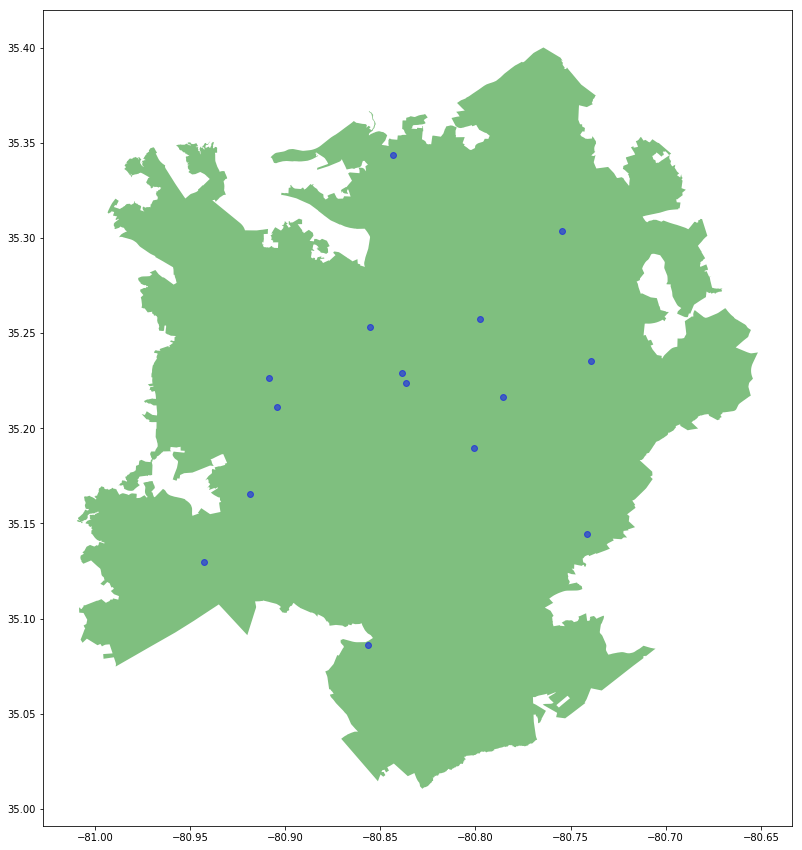

In [4]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='green', alpha=0.5)
df.plot(ax=ax, color='blue', alpha=0.5)

# Buffer

To solve the projection problem for the buffer, I'm gonna follow [this answer][1].

[1]: https://gis.stackexchange.com/a/289923

In [5]:
def get_buffer(point, distance, crs):
    to_nad83 = functools.partial(
        pyproj.transform,
        pyproj.Proj(crs),
        pyproj.Proj(util.crs.epsg4269),
    )
    point_nad83 = shapely.ops.transform(to_nad83, point)
    proj = {
        'proj': 'aeqd',
        'lat_0': point_nad83.y,
        'lon_0': point_nad83.x,
        'x_0': 0,
        'y_0': 0,
        'ellps': 'GRS80',
        'datum': 'NAD83',
        'units': 'm',
        'no_defs': True,
    }

    to_original_proj = functools.partial(
        pyproj.transform,
        pyproj.Proj(proj),
        pyproj.Proj(crs),
    )
    buffer = Point(0, 0).buffer(distance)
    buffer = shapely.ops.transform(to_original_proj, buffer)
    
    return buffer

def points_to_radius(ser, distance):
    radius = [get_buffer(x, distance, ser.crs) for x in ser]
    return gpd.GeoSeries(radius, crs=ser.crs, index=ser.index)

In [6]:
radius = points_to_radius(df.geometry, 1500)

df1 = df.copy()
df1.geometry = radius

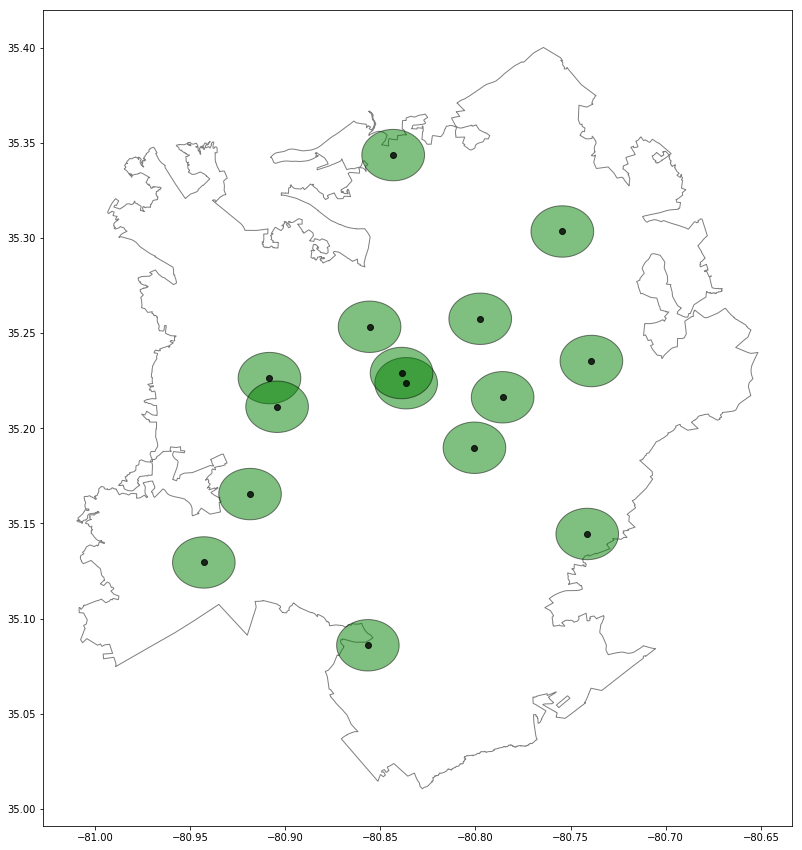

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

city.plot(ax=ax, color='none', edgecolor='black', alpha=0.5)
df1.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)
df.plot(ax=ax, color='k', alpha=0.8);

*compare with previous notebook*

In [8]:
df1.bounds

,minx,miny,maxx,maxy
0,-80.959273,35.115954,-80.926358,35.142995
1,-80.873021,35.072415,-80.840123,35.099456
2,-80.802210,35.202789,-80.769260,35.229830
3,-80.852933,35.210170,-80.819980,35.237210
4,-80.924777,35.212867,-80.891823,35.239907
5,-80.817018,35.176248,-80.784079,35.203289
6,-80.757716,35.130929,-80.724795,35.157970
7,-80.755552,35.221851,-80.722594,35.248892
8,-80.855336,35.215542,-80.822381,35.242582
9,-80.813999,35.244062,-80.781032,35.271102
